In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, recall_score, precision_score
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Input, Dropout

from tqdm import tqdm
from joblib import dump, load

In [2]:
df = pd.read_csv("heloc_processed.csv")

In [3]:
df = df.drop(df.columns[0], axis=1)

In [4]:
df

,RiskPerformance,ExternalRiskEstimate,MSinceOldestTradeOpen,MSinceMostRecentTradeOpen,AverageMInFile,NumSatisfactoryTrades,NumTrades60Ever2DerogPubRec,PercentTradesNeverDelq,MSinceMostRecentDelq,MaxDelq2PublicRecLast12M,...,NumTradesOpeninLast12M,PercentInstallTrades,MSinceMostRecentInqexcl7days,NumInqLast6M,NetFractionRevolvingBurden,NetFractionInstallBurden,NumRevolvingTradesWBalance,NumInstallTradesWBalance,NumBank2NatlTradesWHighUtilization,PercentTradesWBalance
0,1,55.0,144.0,2.321928,84,20,2.000000,83,2.0,3,...,1,43,0.000000,0.000000,33.0,NaN,8.0,1.000000,1.0,69.0
1,1,61.0,58.0,4.000000,41,2,2.321928,100,NaN,0,...,0,67,0.000000,0.000000,0.0,NaN,0.0,NaN,NaN,0.0
2,1,67.0,66.0,2.584963,24,9,0.000000,100,NaN,7,...,4,44,0.000000,2.321928,53.0,66.0,4.0,1.584963,1.0,86.0
3,1,66.0,169.0,1.000000,73,28,1.000000,93,76.0,6,...,3,57,0.000000,2.584963,72.0,83.0,6.0,2.321928,2.0,91.0
4,1,81.0,333.0,4.807355,132,12,0.000000,100,NaN,7,...,0,25,0.000000,1.000000,51.0,89.0,3.0,1.000000,0.0,80.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9768,0,73.0,131.0,2.584963,57,21,0.000000,95,80.0,6,...,5,19,3.000000,0.000000,26.0,NaN,5.0,1.584963,0.0,100.0
9769,1,65.0,147.0,5.321928,68,11,0.000000,92,28.0,6,...,0,42,1.000000,1.000000,86.0,53.0,2.0,1.584963,1.0,80.0
9770,1,74.0,129.0,2.807355,64,18,1.000000,100,NaN,6,...,1,33,2.000000,2.321928,6.0,NaN,5.0,NaN,0.0,56.0
9771,1,72.0,234.0,3.700440,113,42,1.584963,96,35.0,6,...,0,20,2.807355,0.000000,19.0,NaN,4.0,1.000000,0.0,38.0


## RandomForestClassifier

Progreso: 100%|██████████| 20/20 [02:41<00:00,  8.05s/it]


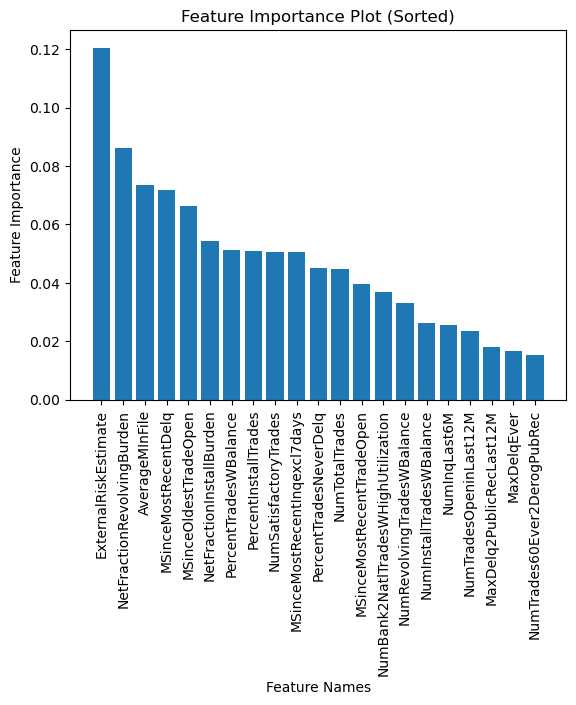

Modelo: RandomForestClassifier(random_state=42)
Vecinos: 7
Precision: 0.7336136059621632
Recall: 0.7558574522543808
F1 Score: 0.7445694336695112
Accuracy: 0.7304819400388827
AUC: 0.7294412953645146
Modelo guardado como 'modelo_rfc.joblib'


In [5]:
best_results = {"Modelo": None, "Precision": 0 ,"Accuracy": 0, "Recall": 0, "F1": 0, "AUC": 0, "Vecinos": 0}

for neighbors in tqdm(range(1, 21), desc="Progreso"):
    imputer = KNNImputer(n_neighbors=neighbors)
    df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)
    X = df_imputed.drop(["RiskPerformance"], axis=1)
    y = df_imputed["RiskPerformance"]

    model = RandomForestClassifier(random_state=42)

    cv_predictions = cross_val_predict(model, X, y, cv=5)

    avg_precision = precision_score(y, cv_predictions)
    avg_accuracy  = accuracy_score(y, cv_predictions)
    avg_recall    = recall_score(y, cv_predictions)
    avg_auc       = roc_auc_score(y, cv_predictions)
    avg_f1        = f1_score(y, cv_predictions)

    if avg_precision > best_results["Precision"]:
        best_results["Modelo"]    = model
        best_results["Precision"] = avg_precision
        best_results["Accuracy"]  = avg_accuracy
        best_results["Recall"]    = avg_recall
        best_results["F1"]        = avg_f1
        best_results["AUC"]       = avg_auc
        best_results["Vecinos"]   = neighbors
        df_imputer = imputer

df_final = pd.DataFrame(df_imputer.transform(df), columns=df.columns)
best_model = best_results["Modelo"]
best_model.fit(X, y)
feature_importance = best_model.feature_importances_
feature_names = X.columns

feature_importance_sorted = sorted(zip(feature_names, feature_importance), key=lambda x: x[1], reverse=True)
sorted_feature_names, sorted_feature_importance = zip(*feature_importance_sorted)

plt.bar(sorted_feature_names, sorted_feature_importance)
plt.xlabel('Feature Names')
plt.ylabel('Feature Importance')
plt.title('Feature Importance Plot (Sorted)')
plt.xticks(rotation=90)
plt.show()


dump(best_model, 'modelo_rfc.joblib')

print("Modelo:"   , best_results["Modelo"])
print("Vecinos:"  , best_results["Vecinos"])
print("Precision:", best_results["Precision"])
print("Recall:"   , best_results["Recall"])
print("F1 Score:" , best_results["F1"])
print("Accuracy:" , best_results["Accuracy"])
print("AUC:"      , best_results["AUC"])
print("Modelo guardado como 'modelo_rfc.joblib'")

In [6]:
df_final.to_csv('df_final_7k.csv', index=False)

## Red StandardScaler

In [7]:
tf.random.set_seed(42)

best_results = {"Modelo": None, "Precision": 0, "Recall": 0,  "Accuracy": 0, "F1_Score": 0, "AUC": 0, "Vecinos": 0}

for neighbors in tqdm(range(1, 21), desc="Progreso"):
    df_imputed = pd.DataFrame(KNNImputer().fit_transform(df), columns=df.columns)
    X = df_imputed.drop("RiskPerformance", axis=1)
    y = df_imputed["RiskPerformance"]

    X_scaled = StandardScaler().fit_transform(X)

    input_nodes  = X_scaled.shape[1]
    output_nodes = 1

    model = Sequential()
    model.add(Input((input_nodes,)))
    model.add(Dense(64, activation="relu"))
    model.add(Dropout(0.3, seed=0))
    model.add(Dense(32, activation="relu"))
    model.add(Dropout(0.3, seed=1))
    model.add(Dense(16, activation="relu"))
    model.add(Dropout(0.3, seed=2))
    model.add(Dense(output_nodes))
    model.compile(optimizer="adam", loss="mean_squared_logarithmic_error")

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    precision_scores, recall_scores, f1_scores, auc_scores, accuracy_scores = [], [], [], [], []

    for train_index, test_index in skf.split(X_scaled, y):
        X_train, X_test = X_scaled[train_index], X_scaled[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
        history = model.fit(
            X_train,
            y_train,
            epochs=100,
            validation_data=(X_test, y_test),
            verbose=2
        )
    
        y_pred = (model.predict(X_test) > 0.5).astype(int)
    
        precision = precision_score(y_test, y_pred)
        recall    = recall_score(y_test, y_pred)
        f1        = f1_score(y_test, y_pred)
        auc       = roc_auc_score(y_test, y_pred)
        accuracy  = accuracy_score(y_test, y_pred)
    
        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_scores.append(f1)
        auc_scores.append(auc)
        accuracy_scores.append(accuracy)

        avg_precision = np.mean(precision_scores)
        avg_recall    = np.mean(recall_scores)
        avg_f1        = np.mean(f1_scores)
        avg_auc       = np.mean(auc_scores)
        avg_accuracy  = np.mean(accuracy_scores)

    if avg_f1 > best_results["Precision"]:
        best_results["Modelo"]    = model
        best_results["Precision"] = avg_precision
        best_results["Accuracy"]  = avg_accuracy
        best_results["Recall"]    = avg_recall
        best_results["F1_Score"]  = avg_f1
        best_results["AUC"]       = avg_auc
        best_results["Vecinos"]   = neighbors
        df_imputer = imputer
        
df_final_red = pd.DataFrame(df_imputer.transform(df), columns=df.columns)
best_results["Modelo"].save('modelo_red_neuronal_seq.h5')

print("Modelo:"   , best_results["Modelo"])
print("Vecinos:"  , best_results["Vecinos"])
print("Precision:", best_results["Precision"])
print("Recall:"   , best_results["Recall"])
print("F1 Score:" , best_results["F1_Score"])
print("Accuracy:" , best_results["Accuracy"])
print("AUC:"      , best_results["AUC"])
print("Modelo guardado como 'modelo_red_neuronal_seq.h5'")

Progreso:   0%|          | 0/20 [00:00<?, ?it/s]



Epoch 1/100

245/245 - 1s - loss: 0.1450 - val_loss: 0.0963 - 763ms/epoch - 3ms/step
Epoch 2/100
245/245 - 0s - loss: 0.1084 - val_loss: 0.0940 - 203ms/epoch - 830us/step
Epoch 3/100
245/245 - 0s - loss: 0.1008 - val_loss: 0.0919 - 204ms/epoch - 834us/step
Epoch 4/100
245/245 - 0s - loss: 0.0994 - val_loss: 0.0931 - 204ms/epoch - 834us/step
Epoch 5/100
245/245 - 0s - loss: 0.0957 - val_loss: 0.0887 - 202ms/epoch - 824us/step
Epoch 6/100
245/245 - 0s - loss: 0.0944 - val_loss: 0.0884 - 199ms/epoch - 811us/step
Epoch 7/100
245/245 - 0s - loss: 0.0937 - val_loss: 0.0892 - 204ms/epoch - 834us/step
Epoch 8/100
245/245 - 0s - loss: 0.0933 - val_loss: 0.0885 - 206ms/epoch - 841us/step
Epoch 9/100
245/245 - 0s - loss: 0.0928 - val_loss: 0.0877 - 204ms/epoch - 834us/step
Epoch 10/100
245/245 - 0s - loss: 0.0917 - val_loss: 0.0875 - 205ms/epoch - 837us/step
Epoch 11/100
245/245 - 0s - loss: 0.0922 - val_loss: 0.0869 - 203ms/epoch - 827us/step
Epoch 12/100
245/245 - 0s - loss: 0.0918 - val_loss

Progreso:   5%|▌         | 1/20 [01:50<34:51, 110.05s/it]

Epoch 1/100
245/245 - 1s - loss: 0.1450 - val_loss: 0.0958 - 668ms/epoch - 3ms/step
Epoch 2/100
245/245 - 0s - loss: 0.1079 - val_loss: 0.0949 - 211ms/epoch - 862us/step
Epoch 3/100
245/245 - 0s - loss: 0.0996 - val_loss: 0.0912 - 206ms/epoch - 842us/step
Epoch 4/100
245/245 - 0s - loss: 0.0983 - val_loss: 0.0934 - 206ms/epoch - 842us/step
Epoch 5/100
245/245 - 0s - loss: 0.0967 - val_loss: 0.0886 - 204ms/epoch - 832us/step
Epoch 6/100
245/245 - 0s - loss: 0.0945 - val_loss: 0.0876 - 209ms/epoch - 853us/step
Epoch 7/100
245/245 - 0s - loss: 0.0938 - val_loss: 0.0873 - 213ms/epoch - 870us/step
Epoch 8/100
245/245 - 0s - loss: 0.0935 - val_loss: 0.0895 - 215ms/epoch - 878us/step
Epoch 9/100
245/245 - 0s - loss: 0.0931 - val_loss: 0.0878 - 213ms/epoch - 870us/step
Epoch 10/100
245/245 - 0s - loss: 0.0925 - val_loss: 0.0881 - 208ms/epoch - 848us/step
Epoch 11/100
245/245 - 0s - loss: 0.0923 - val_loss: 0.0860 - 216ms/epoch - 881us/step
Epoch 12/100
245/245 - 0s - loss: 0.0918 - val_loss: 0

Progreso:  10%|█         | 2/20 [03:39<32:51, 109.53s/it]

Epoch 1/100
245/245 - 1s - loss: 0.1395 - val_loss: 0.0969 - 661ms/epoch - 3ms/step
Epoch 2/100
245/245 - 0s - loss: 0.1060 - val_loss: 0.0956 - 208ms/epoch - 848us/step
Epoch 3/100
245/245 - 0s - loss: 0.1010 - val_loss: 0.0923 - 204ms/epoch - 832us/step
Epoch 4/100
245/245 - 0s - loss: 0.0977 - val_loss: 0.0944 - 208ms/epoch - 850us/step
Epoch 5/100
245/245 - 0s - loss: 0.0964 - val_loss: 0.0918 - 204ms/epoch - 834us/step
Epoch 6/100
245/245 - 0s - loss: 0.0952 - val_loss: 0.0895 - 209ms/epoch - 855us/step
Epoch 7/100
245/245 - 0s - loss: 0.0943 - val_loss: 0.0912 - 204ms/epoch - 834us/step
Epoch 8/100
245/245 - 0s - loss: 0.0941 - val_loss: 0.0910 - 205ms/epoch - 837us/step
Epoch 9/100
245/245 - 0s - loss: 0.0934 - val_loss: 0.0882 - 206ms/epoch - 842us/step
Epoch 10/100
245/245 - 0s - loss: 0.0927 - val_loss: 0.0904 - 204ms/epoch - 834us/step
Epoch 11/100
245/245 - 0s - loss: 0.0927 - val_loss: 0.0882 - 209ms/epoch - 852us/step
Epoch 12/100
245/245 - 0s - loss: 0.0915 - val_loss: 0

Progreso:  15%|█▌        | 3/20 [05:28<30:57, 109.29s/it]

Epoch 1/100
245/245 - 1s - loss: 0.1331 - val_loss: 0.0937 - 659ms/epoch - 3ms/step
Epoch 2/100
245/245 - 0s - loss: 0.1048 - val_loss: 0.0914 - 217ms/epoch - 888us/step
Epoch 3/100
245/245 - 0s - loss: 0.1011 - val_loss: 0.0889 - 230ms/epoch - 939us/step
Epoch 4/100
245/245 - 0s - loss: 0.0974 - val_loss: 0.0905 - 227ms/epoch - 925us/step
Epoch 5/100
245/245 - 0s - loss: 0.0962 - val_loss: 0.0870 - 223ms/epoch - 908us/step
Epoch 6/100
245/245 - 0s - loss: 0.0950 - val_loss: 0.0865 - 216ms/epoch - 882us/step
Epoch 7/100
245/245 - 0s - loss: 0.0945 - val_loss: 0.0879 - 223ms/epoch - 909us/step
Epoch 8/100
245/245 - 0s - loss: 0.0935 - val_loss: 0.0875 - 210ms/epoch - 859us/step
Epoch 9/100
245/245 - 0s - loss: 0.0925 - val_loss: 0.0851 - 220ms/epoch - 899us/step
Epoch 10/100
245/245 - 0s - loss: 0.0930 - val_loss: 0.0875 - 212ms/epoch - 866us/step
Epoch 11/100
245/245 - 0s - loss: 0.0927 - val_loss: 0.0862 - 221ms/epoch - 904us/step
Epoch 12/100
245/245 - 0s - loss: 0.0923 - val_loss: 0

Progreso:  20%|██        | 4/20 [07:18<29:17, 109.84s/it]

Epoch 1/100
245/245 - 1s - loss: 0.1693 - val_loss: 0.0898 - 649ms/epoch - 3ms/step
Epoch 2/100
245/245 - 0s - loss: 0.1104 - val_loss: 0.0910 - 213ms/epoch - 870us/step
Epoch 3/100
245/245 - 0s - loss: 0.1021 - val_loss: 0.0895 - 215ms/epoch - 876us/step
Epoch 4/100
245/245 - 0s - loss: 0.0988 - val_loss: 0.0920 - 206ms/epoch - 841us/step
Epoch 5/100
245/245 - 0s - loss: 0.0965 - val_loss: 0.0894 - 212ms/epoch - 866us/step
Epoch 6/100
245/245 - 0s - loss: 0.0943 - val_loss: 0.0885 - 209ms/epoch - 853us/step
Epoch 7/100
245/245 - 0s - loss: 0.0945 - val_loss: 0.0891 - 211ms/epoch - 863us/step
Epoch 8/100
245/245 - 0s - loss: 0.0941 - val_loss: 0.0894 - 210ms/epoch - 857us/step
Epoch 9/100
245/245 - 0s - loss: 0.0931 - val_loss: 0.0882 - 211ms/epoch - 861us/step
Epoch 10/100
245/245 - 0s - loss: 0.0935 - val_loss: 0.0886 - 212ms/epoch - 867us/step
Epoch 11/100
245/245 - 0s - loss: 0.0925 - val_loss: 0.0861 - 216ms/epoch - 881us/step
Epoch 12/100
245/245 - 0s - loss: 0.0928 - val_loss: 0

Progreso:  25%|██▌       | 5/20 [09:11<27:42, 110.84s/it]

Epoch 1/100
245/245 - 1s - loss: 0.1409 - val_loss: 0.0970 - 667ms/epoch - 3ms/step
Epoch 2/100
245/245 - 0s - loss: 0.1086 - val_loss: 0.0949 - 225ms/epoch - 919us/step
Epoch 3/100
245/245 - 0s - loss: 0.1003 - val_loss: 0.0921 - 213ms/epoch - 871us/step
Epoch 4/100
245/245 - 0s - loss: 0.0977 - val_loss: 0.0932 - 216ms/epoch - 884us/step
Epoch 5/100
245/245 - 0s - loss: 0.0961 - val_loss: 0.0882 - 218ms/epoch - 890us/step
Epoch 6/100
245/245 - 0s - loss: 0.0945 - val_loss: 0.0880 - 218ms/epoch - 889us/step
Epoch 7/100
245/245 - 0s - loss: 0.0944 - val_loss: 0.0883 - 212ms/epoch - 866us/step
Epoch 8/100
245/245 - 0s - loss: 0.0929 - val_loss: 0.0906 - 207ms/epoch - 847us/step
Epoch 9/100
245/245 - 0s - loss: 0.0928 - val_loss: 0.0870 - 226ms/epoch - 921us/step
Epoch 10/100
245/245 - 0s - loss: 0.0926 - val_loss: 0.0871 - 216ms/epoch - 880us/step
Epoch 11/100
245/245 - 0s - loss: 0.0920 - val_loss: 0.0866 - 224ms/epoch - 914us/step
Epoch 12/100
245/245 - 0s - loss: 0.0916 - val_loss: 0

Progreso:  30%|███       | 6/20 [11:02<25:53, 110.96s/it]

Epoch 1/100
245/245 - 1s - loss: 0.1304 - val_loss: 0.1014 - 660ms/epoch - 3ms/step
Epoch 2/100
245/245 - 0s - loss: 0.1074 - val_loss: 0.0978 - 209ms/epoch - 854us/step
Epoch 3/100
245/245 - 0s - loss: 0.1019 - val_loss: 0.0935 - 210ms/epoch - 856us/step
Epoch 4/100
245/245 - 0s - loss: 0.0990 - val_loss: 0.0964 - 209ms/epoch - 854us/step
Epoch 5/100
245/245 - 0s - loss: 0.0967 - val_loss: 0.0935 - 210ms/epoch - 856us/step
Epoch 6/100
245/245 - 0s - loss: 0.0953 - val_loss: 0.0895 - 207ms/epoch - 844us/step
Epoch 7/100
245/245 - 0s - loss: 0.0942 - val_loss: 0.0921 - 210ms/epoch - 856us/step
Epoch 8/100
245/245 - 0s - loss: 0.0933 - val_loss: 0.0901 - 209ms/epoch - 854us/step
Epoch 9/100
245/245 - 0s - loss: 0.0933 - val_loss: 0.0901 - 206ms/epoch - 842us/step
Epoch 10/100
245/245 - 0s - loss: 0.0927 - val_loss: 0.0916 - 210ms/epoch - 856us/step
Epoch 11/100
245/245 - 0s - loss: 0.0921 - val_loss: 0.0882 - 210ms/epoch - 856us/step
Epoch 12/100
245/245 - 0s - loss: 0.0923 - val_loss: 0

Progreso:  35%|███▌      | 7/20 [12:54<24:06, 111.24s/it]

Epoch 1/100
245/245 - 1s - loss: 0.1459 - val_loss: 0.0992 - 683ms/epoch - 3ms/step
Epoch 2/100
245/245 - 0s - loss: 0.1104 - val_loss: 0.0978 - 218ms/epoch - 888us/step
Epoch 3/100
245/245 - 0s - loss: 0.1011 - val_loss: 0.0950 - 228ms/epoch - 929us/step
Epoch 4/100
245/245 - 0s - loss: 0.1003 - val_loss: 0.0965 - 221ms/epoch - 902us/step
Epoch 5/100
245/245 - 0s - loss: 0.0974 - val_loss: 0.0892 - 211ms/epoch - 861us/step
Epoch 6/100
245/245 - 0s - loss: 0.0964 - val_loss: 0.0901 - 210ms/epoch - 856us/step
Epoch 7/100
245/245 - 0s - loss: 0.0956 - val_loss: 0.0899 - 221ms/epoch - 901us/step
Epoch 8/100
245/245 - 0s - loss: 0.0944 - val_loss: 0.0898 - 213ms/epoch - 871us/step
Epoch 9/100
245/245 - 0s - loss: 0.0942 - val_loss: 0.0884 - 219ms/epoch - 894us/step
Epoch 10/100
245/245 - 0s - loss: 0.0943 - val_loss: 0.0897 - 225ms/epoch - 918us/step
Epoch 11/100
245/245 - 0s - loss: 0.0925 - val_loss: 0.0869 - 217ms/epoch - 886us/step
Epoch 12/100
245/245 - 0s - loss: 0.0935 - val_loss: 0

Progreso:  40%|████      | 8/20 [14:46<22:18, 111.55s/it]

Epoch 1/100
245/245 - 1s - loss: 0.1590 - val_loss: 0.1046 - 684ms/epoch - 3ms/step
Epoch 2/100
245/245 - 0s - loss: 0.1125 - val_loss: 0.0970 - 215ms/epoch - 877us/step
Epoch 3/100
245/245 - 0s - loss: 0.1051 - val_loss: 0.0933 - 213ms/epoch - 868us/step
Epoch 4/100
245/245 - 0s - loss: 0.1004 - val_loss: 0.0949 - 230ms/epoch - 940us/step
Epoch 5/100
245/245 - 0s - loss: 0.0969 - val_loss: 0.0902 - 235ms/epoch - 957us/step
Epoch 6/100
245/245 - 0s - loss: 0.0962 - val_loss: 0.0884 - 223ms/epoch - 911us/step
Epoch 7/100
245/245 - 0s - loss: 0.0963 - val_loss: 0.0900 - 230ms/epoch - 940us/step
Epoch 8/100
245/245 - 0s - loss: 0.0949 - val_loss: 0.0897 - 222ms/epoch - 906us/step
Epoch 9/100
245/245 - 0s - loss: 0.0953 - val_loss: 0.0887 - 212ms/epoch - 864us/step
Epoch 10/100
245/245 - 0s - loss: 0.0925 - val_loss: 0.0899 - 217ms/epoch - 884us/step
Epoch 11/100
245/245 - 0s - loss: 0.0936 - val_loss: 0.0882 - 227ms/epoch - 927us/step
Epoch 12/100
245/245 - 0s - loss: 0.0934 - val_loss: 0

Progreso:  45%|████▌     | 9/20 [16:39<20:32, 112.03s/it]

Epoch 1/100
245/245 - 1s - loss: 0.1427 - val_loss: 0.1013 - 680ms/epoch - 3ms/step
Epoch 2/100
245/245 - 0s - loss: 0.1086 - val_loss: 0.0965 - 218ms/epoch - 888us/step
Epoch 3/100
245/245 - 0s - loss: 0.1010 - val_loss: 0.0917 - 206ms/epoch - 840us/step
Epoch 4/100
245/245 - 0s - loss: 0.0979 - val_loss: 0.0935 - 224ms/epoch - 913us/step
Epoch 5/100
245/245 - 0s - loss: 0.0960 - val_loss: 0.0892 - 216ms/epoch - 882us/step
Epoch 6/100
245/245 - 0s - loss: 0.0946 - val_loss: 0.0874 - 209ms/epoch - 851us/step
Epoch 7/100
245/245 - 0s - loss: 0.0938 - val_loss: 0.0889 - 215ms/epoch - 877us/step
Epoch 8/100
245/245 - 0s - loss: 0.0933 - val_loss: 0.0886 - 214ms/epoch - 875us/step
Epoch 9/100
245/245 - 0s - loss: 0.0933 - val_loss: 0.0872 - 218ms/epoch - 889us/step
Epoch 10/100
245/245 - 0s - loss: 0.0919 - val_loss: 0.0871 - 226ms/epoch - 921us/step
Epoch 11/100
245/245 - 0s - loss: 0.0916 - val_loss: 0.0863 - 213ms/epoch - 869us/step
Epoch 12/100
245/245 - 0s - loss: 0.0918 - val_loss: 0

Progreso:  50%|█████     | 10/20 [18:30<18:36, 111.65s/it]

Epoch 1/100
245/245 - 1s - loss: 0.1491 - val_loss: 0.0965 - 673ms/epoch - 3ms/step
Epoch 2/100
245/245 - 0s - loss: 0.1069 - val_loss: 0.0938 - 221ms/epoch - 901us/step
Epoch 3/100
245/245 - 0s - loss: 0.1031 - val_loss: 0.0904 - 223ms/epoch - 909us/step
Epoch 4/100
245/245 - 0s - loss: 0.0996 - val_loss: 0.0922 - 217ms/epoch - 884us/step
Epoch 5/100
245/245 - 0s - loss: 0.0963 - val_loss: 0.0886 - 220ms/epoch - 898us/step
Epoch 6/100
245/245 - 0s - loss: 0.0959 - val_loss: 0.0881 - 215ms/epoch - 878us/step
Epoch 7/100
245/245 - 0s - loss: 0.0954 - val_loss: 0.0884 - 213ms/epoch - 871us/step
Epoch 8/100
245/245 - 0s - loss: 0.0946 - val_loss: 0.0884 - 214ms/epoch - 872us/step
Epoch 9/100
245/245 - 0s - loss: 0.0943 - val_loss: 0.0864 - 217ms/epoch - 888us/step
Epoch 10/100
245/245 - 0s - loss: 0.0928 - val_loss: 0.0872 - 219ms/epoch - 893us/step
Epoch 11/100
245/245 - 0s - loss: 0.0925 - val_loss: 0.0865 - 224ms/epoch - 913us/step
Epoch 12/100
245/245 - 0s - loss: 0.0925 - val_loss: 0

Progreso:  55%|█████▌    | 11/20 [20:25<16:53, 112.59s/it]

Epoch 1/100
245/245 - 2s - loss: 0.1375 - val_loss: 0.0941 - 2s/epoch - 6ms/step
Epoch 2/100
245/245 - 1s - loss: 0.1053 - val_loss: 0.0925 - 509ms/epoch - 2ms/step
Epoch 3/100
245/245 - 0s - loss: 0.1004 - val_loss: 0.0909 - 421ms/epoch - 2ms/step
Epoch 4/100
245/245 - 1s - loss: 0.0961 - val_loss: 0.0941 - 501ms/epoch - 2ms/step
Epoch 5/100
245/245 - 1s - loss: 0.0955 - val_loss: 0.0890 - 538ms/epoch - 2ms/step
Epoch 6/100
245/245 - 1s - loss: 0.0950 - val_loss: 0.0875 - 563ms/epoch - 2ms/step
Epoch 7/100
245/245 - 0s - loss: 0.0941 - val_loss: 0.0879 - 412ms/epoch - 2ms/step
Epoch 8/100
245/245 - 0s - loss: 0.0930 - val_loss: 0.0887 - 483ms/epoch - 2ms/step
Epoch 9/100
245/245 - 0s - loss: 0.0934 - val_loss: 0.0869 - 417ms/epoch - 2ms/step
Epoch 10/100
245/245 - 0s - loss: 0.0925 - val_loss: 0.0884 - 404ms/epoch - 2ms/step
Epoch 11/100
245/245 - 1s - loss: 0.0922 - val_loss: 0.0871 - 539ms/epoch - 2ms/step
Epoch 12/100
245/245 - 1s - loss: 0.0926 - val_loss: 0.0884 - 514ms/epoch - 2

Progreso:  60%|██████    | 12/20 [22:45<16:06, 120.86s/it]

Epoch 1/100
245/245 - 1s - loss: 0.1427 - val_loss: 0.1045 - 734ms/epoch - 3ms/step
Epoch 2/100
245/245 - 0s - loss: 0.1088 - val_loss: 0.0993 - 228ms/epoch - 932us/step
Epoch 3/100
245/245 - 0s - loss: 0.1027 - val_loss: 0.0929 - 208ms/epoch - 849us/step
Epoch 4/100
245/245 - 0s - loss: 0.0988 - val_loss: 0.0936 - 220ms/epoch - 897us/step
Epoch 5/100
245/245 - 0s - loss: 0.0971 - val_loss: 0.0886 - 207ms/epoch - 847us/step
Epoch 6/100
245/245 - 0s - loss: 0.0948 - val_loss: 0.0872 - 205ms/epoch - 835us/step
Epoch 7/100
245/245 - 0s - loss: 0.0936 - val_loss: 0.0879 - 218ms/epoch - 888us/step
Epoch 8/100
245/245 - 0s - loss: 0.0934 - val_loss: 0.0877 - 211ms/epoch - 863us/step
Epoch 9/100
245/245 - 0s - loss: 0.0927 - val_loss: 0.0875 - 204ms/epoch - 833us/step
Epoch 10/100
245/245 - 0s - loss: 0.0938 - val_loss: 0.0880 - 204ms/epoch - 834us/step
Epoch 11/100
245/245 - 0s - loss: 0.0930 - val_loss: 0.0883 - 219ms/epoch - 895us/step
Epoch 12/100
245/245 - 0s - loss: 0.0919 - val_loss: 0

Progreso:  65%|██████▌   | 13/20 [24:36<13:45, 117.89s/it]

Epoch 1/100
245/245 - 1s - loss: 0.1477 - val_loss: 0.1032 - 654ms/epoch - 3ms/step
Epoch 2/100
245/245 - 0s - loss: 0.1108 - val_loss: 0.0984 - 213ms/epoch - 870us/step
Epoch 3/100
245/245 - 0s - loss: 0.1032 - val_loss: 0.0937 - 223ms/epoch - 911us/step
Epoch 4/100
245/245 - 0s - loss: 0.0997 - val_loss: 0.0935 - 232ms/epoch - 947us/step
Epoch 5/100
245/245 - 0s - loss: 0.0974 - val_loss: 0.0918 - 206ms/epoch - 839us/step
Epoch 6/100
245/245 - 0s - loss: 0.0972 - val_loss: 0.0886 - 213ms/epoch - 870us/step
Epoch 7/100
245/245 - 0s - loss: 0.0957 - val_loss: 0.0897 - 206ms/epoch - 841us/step
Epoch 8/100
245/245 - 0s - loss: 0.0953 - val_loss: 0.0908 - 223ms/epoch - 910us/step
Epoch 9/100
245/245 - 0s - loss: 0.0943 - val_loss: 0.0875 - 216ms/epoch - 883us/step
Epoch 10/100
245/245 - 0s - loss: 0.0933 - val_loss: 0.0893 - 212ms/epoch - 864us/step
Epoch 11/100
245/245 - 0s - loss: 0.0931 - val_loss: 0.0871 - 209ms/epoch - 854us/step
Epoch 12/100
245/245 - 0s - loss: 0.0929 - val_loss: 0

Progreso:  70%|███████   | 14/20 [26:28<11:37, 116.33s/it]

Epoch 1/100
245/245 - 1s - loss: 0.1349 - val_loss: 0.0948 - 661ms/epoch - 3ms/step
Epoch 2/100
245/245 - 0s - loss: 0.1052 - val_loss: 0.0925 - 203ms/epoch - 827us/step
Epoch 3/100
245/245 - 0s - loss: 0.1003 - val_loss: 0.0901 - 200ms/epoch - 815us/step
Epoch 4/100
245/245 - 0s - loss: 0.0986 - val_loss: 0.0929 - 202ms/epoch - 825us/step
Epoch 5/100
245/245 - 0s - loss: 0.0951 - val_loss: 0.0874 - 203ms/epoch - 830us/step
Epoch 6/100
245/245 - 0s - loss: 0.0942 - val_loss: 0.0877 - 203ms/epoch - 828us/step
Epoch 7/100
245/245 - 0s - loss: 0.0932 - val_loss: 0.0876 - 204ms/epoch - 831us/step
Epoch 8/100
245/245 - 0s - loss: 0.0924 - val_loss: 0.0884 - 203ms/epoch - 829us/step
Epoch 9/100
245/245 - 0s - loss: 0.0915 - val_loss: 0.0871 - 206ms/epoch - 842us/step
Epoch 10/100
245/245 - 0s - loss: 0.0914 - val_loss: 0.0873 - 222ms/epoch - 905us/step
Epoch 11/100
245/245 - 0s - loss: 0.0913 - val_loss: 0.0865 - 229ms/epoch - 936us/step
Epoch 12/100
245/245 - 0s - loss: 0.0913 - val_loss: 0

Progreso:  75%|███████▌  | 15/20 [28:18<09:31, 114.38s/it]

Epoch 1/100
245/245 - 1s - loss: 0.1317 - val_loss: 0.0928 - 682ms/epoch - 3ms/step
Epoch 2/100
245/245 - 0s - loss: 0.1044 - val_loss: 0.0904 - 218ms/epoch - 890us/step
Epoch 3/100
245/245 - 0s - loss: 0.0989 - val_loss: 0.0882 - 213ms/epoch - 870us/step
Epoch 4/100
245/245 - 0s - loss: 0.0964 - val_loss: 0.0905 - 208ms/epoch - 851us/step
Epoch 5/100
245/245 - 0s - loss: 0.0948 - val_loss: 0.0870 - 206ms/epoch - 840us/step
Epoch 6/100
245/245 - 0s - loss: 0.0944 - val_loss: 0.0860 - 243ms/epoch - 992us/step
Epoch 7/100
245/245 - 0s - loss: 0.0934 - val_loss: 0.0883 - 213ms/epoch - 869us/step
Epoch 8/100
245/245 - 0s - loss: 0.0925 - val_loss: 0.0874 - 214ms/epoch - 873us/step
Epoch 9/100
245/245 - 0s - loss: 0.0928 - val_loss: 0.0861 - 227ms/epoch - 928us/step
Epoch 10/100
245/245 - 0s - loss: 0.0925 - val_loss: 0.0878 - 223ms/epoch - 911us/step
Epoch 11/100
245/245 - 0s - loss: 0.0919 - val_loss: 0.0856 - 211ms/epoch - 861us/step
Epoch 12/100
245/245 - 0s - loss: 0.0911 - val_loss: 0

Progreso:  80%|████████  | 16/20 [30:11<07:36, 114.04s/it]

Epoch 1/100
245/245 - 1s - loss: 0.1355 - val_loss: 0.0960 - 661ms/epoch - 3ms/step
Epoch 2/100
245/245 - 0s - loss: 0.1052 - val_loss: 0.0905 - 208ms/epoch - 848us/step
Epoch 3/100
245/245 - 0s - loss: 0.1004 - val_loss: 0.0902 - 212ms/epoch - 864us/step
Epoch 4/100
245/245 - 0s - loss: 0.0975 - val_loss: 0.0906 - 215ms/epoch - 879us/step
Epoch 5/100
245/245 - 0s - loss: 0.0961 - val_loss: 0.0890 - 213ms/epoch - 869us/step
Epoch 6/100
245/245 - 0s - loss: 0.0952 - val_loss: 0.0865 - 202ms/epoch - 825us/step
Epoch 7/100
245/245 - 0s - loss: 0.0945 - val_loss: 0.0877 - 206ms/epoch - 842us/step
Epoch 8/100
245/245 - 0s - loss: 0.0935 - val_loss: 0.0879 - 205ms/epoch - 837us/step
Epoch 9/100
245/245 - 0s - loss: 0.0922 - val_loss: 0.0861 - 209ms/epoch - 851us/step
Epoch 10/100
245/245 - 0s - loss: 0.0921 - val_loss: 0.0893 - 206ms/epoch - 840us/step
Epoch 11/100
245/245 - 0s - loss: 0.0921 - val_loss: 0.0863 - 207ms/epoch - 843us/step
Epoch 12/100
245/245 - 0s - loss: 0.0916 - val_loss: 0

Progreso:  85%|████████▌ | 17/20 [32:07<05:43, 114.63s/it]

Epoch 1/100
245/245 - 1s - loss: 0.1441 - val_loss: 0.1016 - 713ms/epoch - 3ms/step
Epoch 2/100
245/245 - 0s - loss: 0.1091 - val_loss: 0.0963 - 221ms/epoch - 902us/step
Epoch 3/100
245/245 - 0s - loss: 0.1017 - val_loss: 0.0946 - 227ms/epoch - 927us/step
Epoch 4/100
245/245 - 0s - loss: 0.0989 - val_loss: 0.0963 - 245ms/epoch - 1ms/step
Epoch 5/100
245/245 - 0s - loss: 0.0980 - val_loss: 0.0905 - 227ms/epoch - 926us/step
Epoch 6/100
245/245 - 0s - loss: 0.0963 - val_loss: 0.0878 - 217ms/epoch - 884us/step
Epoch 7/100
245/245 - 0s - loss: 0.0941 - val_loss: 0.0916 - 217ms/epoch - 884us/step
Epoch 8/100
245/245 - 0s - loss: 0.0944 - val_loss: 0.0898 - 236ms/epoch - 962us/step
Epoch 9/100
245/245 - 0s - loss: 0.0937 - val_loss: 0.0873 - 231ms/epoch - 943us/step
Epoch 10/100
245/245 - 0s - loss: 0.0938 - val_loss: 0.0886 - 219ms/epoch - 895us/step
Epoch 11/100
245/245 - 0s - loss: 0.0917 - val_loss: 0.0876 - 221ms/epoch - 901us/step
Epoch 12/100
245/245 - 0s - loss: 0.0924 - val_loss: 0.0

Progreso:  90%|█████████ | 18/20 [34:02<03:49, 114.66s/it]

Epoch 1/100
245/245 - 1s - loss: 0.1379 - val_loss: 0.0996 - 702ms/epoch - 3ms/step
Epoch 2/100
245/245 - 0s - loss: 0.1049 - val_loss: 0.0944 - 228ms/epoch - 932us/step
Epoch 3/100
245/245 - 0s - loss: 0.0998 - val_loss: 0.0902 - 217ms/epoch - 885us/step
Epoch 4/100
245/245 - 0s - loss: 0.0967 - val_loss: 0.0903 - 214ms/epoch - 875us/step
Epoch 5/100
245/245 - 0s - loss: 0.0962 - val_loss: 0.0877 - 224ms/epoch - 915us/step
Epoch 6/100
245/245 - 0s - loss: 0.0940 - val_loss: 0.0868 - 223ms/epoch - 910us/step
Epoch 7/100
245/245 - 0s - loss: 0.0939 - val_loss: 0.0870 - 215ms/epoch - 879us/step
Epoch 8/100
245/245 - 0s - loss: 0.0940 - val_loss: 0.0890 - 233ms/epoch - 952us/step
Epoch 9/100
245/245 - 0s - loss: 0.0916 - val_loss: 0.0877 - 236ms/epoch - 964us/step
Epoch 10/100
245/245 - 0s - loss: 0.0931 - val_loss: 0.0881 - 226ms/epoch - 923us/step
Epoch 11/100
245/245 - 0s - loss: 0.0915 - val_loss: 0.0859 - 212ms/epoch - 866us/step
Epoch 12/100
245/245 - 0s - loss: 0.0917 - val_loss: 0

Progreso:  95%|█████████▌| 19/20 [35:53<01:53, 113.50s/it]

Epoch 1/100
245/245 - 1s - loss: 0.1488 - val_loss: 0.0980 - 643ms/epoch - 3ms/step
Epoch 2/100
245/245 - 0s - loss: 0.1097 - val_loss: 0.0948 - 202ms/epoch - 826us/step
Epoch 3/100
245/245 - 0s - loss: 0.1026 - val_loss: 0.0903 - 203ms/epoch - 830us/step
Epoch 4/100
245/245 - 0s - loss: 0.0982 - val_loss: 0.0918 - 202ms/epoch - 824us/step
Epoch 5/100
245/245 - 0s - loss: 0.0965 - val_loss: 0.0877 - 202ms/epoch - 824us/step
Epoch 6/100
245/245 - 0s - loss: 0.0955 - val_loss: 0.0869 - 204ms/epoch - 834us/step
Epoch 7/100
245/245 - 0s - loss: 0.0945 - val_loss: 0.0871 - 206ms/epoch - 839us/step
Epoch 8/100
245/245 - 0s - loss: 0.0926 - val_loss: 0.0873 - 202ms/epoch - 823us/step
Epoch 9/100
245/245 - 0s - loss: 0.0933 - val_loss: 0.0865 - 203ms/epoch - 828us/step
Epoch 10/100
245/245 - 0s - loss: 0.0921 - val_loss: 0.0886 - 316ms/epoch - 1ms/step
Epoch 11/100
245/245 - 0s - loss: 0.0924 - val_loss: 0.0876 - 210ms/epoch - 858us/step
Epoch 12/100
245/245 - 0s - loss: 0.0923 - val_loss: 0.0

Progreso: 100%|██████████| 20/20 [37:45<00:00, 113.25s/it]


Modelo: <keras.src.engine.sequential.Sequential object at 0x000001DD85FBCD10>
Vecinos: 1
Precision: 0.7982349031979767
Recall: 0.688326674682906
F1 Score: 0.7391547452705634
Accuracy: 0.747368765493826
AUC: 0.7497902688636685
Modelo guardado como 'modelo_red_neuronal_seq.h5'


C:\Users\Adri1\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [8]:
df_final_red.to_csv('df_final_1k.csv', index=False)

# Carga Modelos

In [9]:
load('modelo_rfc.joblib')

RandomForestClassifier(random_state=42)

In [10]:
load_model('modelo_red_neuronal_seq.h5')